## Gradient Boosted Trees Using XGBoost

Decision trees are another standard credit risk model. We will go beyond decision trees by using the trendy XGBoost package in Python to create gradient boosted trees. After developing sophisticated models, we will stress test their performance and discuss column selection in unbalanced data.

### Trees for defaults
You will now train a gradient boosted tree model on the credit data, and see a sample of some of the predictions. Do you remember when you first looked at the predictions of the logistic regression model? They didn't look good. Do you think this model be different?

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# !pip install xgboost 
import xgboost as xgb


# read data
cr_loan = pd.read_csv("cr_loan2.csv")

# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)


# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)



# Create the X and y data sets
X = cr_loan_clean.loc[:, cr_loan_clean.columns != 'loan_status']
X = X.select_dtypes(exclude=['object'])
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)


# Predict with a model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test['loan_status']

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True),preds_df], axis = 1))

[12:52:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
       loan_status  prob_default
0                0      0.061806
1                0      0.120086
2                0      0.009785
3                0      0.054866
4                0      0.482489
...            ...           ...
11781            0           NaN
11782            1           NaN
11783            1           NaN
11784            0           NaN
11785            1           NaN

[11786 rows x 2 columns]


### Assessing gradient boosted trees
So you've now used XGBClassifier() models to predict probability of default. These models can also use the .predict() method for creating predictions that give the actual class for loan_status.

You should check the model's initial performance by looking at the metrics from the classification_report(). Keep in mind that you have not set thresholds for these models yet.

In [28]:
from sklearn.metrics import classification_report

# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(gbt_preds)


# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

[0 0 0 ... 1 0 0]
              precision    recall  f1-score   support

 Non-Default       0.90      0.95      0.92      9194
     Default       0.77      0.62      0.69      2592

    accuracy                           0.88     11786
   macro avg       0.84      0.79      0.81     11786
weighted avg       0.87      0.88      0.87     11786



### Column importance and default prediction
When using multiple training sets with many different groups of columns, it's important to keep and eye on which columns matter and which do not. It can be expensive or time-consuming to maintain a set of columns even though they might not have any impact on loan_status.

In [29]:
# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
print(clf_gbt.get_booster().get_score(importance_type = 'weight'))

C:\Users\Migue\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:52:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'loan_percent_income': 353, 'loan_int_rate': 709, 'person_income': 1023, 'loan_amnt': 509, 'person_emp_length': 346, 'cb_person_cred_hist_length': 233, 'person_age': 392}


### Visualizing column importance
When the model is trained on different sets of columns it changes the performance, but does the importance for the same column change depending on which group it's in?

The data sets X2 and X3 have been created. 

[12:52:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


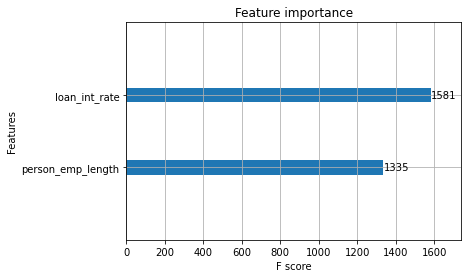

In [30]:
import matplotlib.pyplot as plt

# create variables 
X2 = cr_loan_clean[['loan_int_rate','person_emp_length']]
X3 = cr_loan_clean[['person_income','loan_int_rate','loan_percent_income']]

X_train_2, X_test_2, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)
X_train_3, X_test_3, y_train, y_test = train_test_split(X3, y, test_size=.4, random_state=123)

# Train a model on the X data with 2 columns
clf_gbt_2 = xgb.XGBClassifier().fit(X_train_2,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt_2 , importance_type = 'weight')
plt.show()

[12:52:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


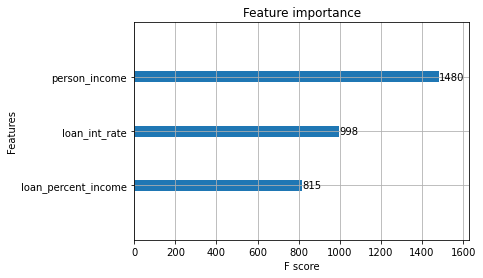

In [31]:
# Train a model on the X data with 2 columns
clf_gbt3 = xgb.XGBClassifier().fit(X_train_3,np.ravel(y_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3 , importance_type = 'weight')
plt.show()

take a closer look at the plots. Did you notice that the importance of loan_int_rate went from 1581 to 815? Initially, this was the most important column, but person_income ended up taking the top spot here.

### Column selection and model performance
Creating the training set from different combinations of columns affects the model and the importance values of the columns. Does a different selection of columns also affect the F-1 scores, the combination of the precision and recall, of the model? You can answer this question by training two different models on two different sets of columns, and checking the performance.

Inaccurately predicting defaults as non-default can result in unexpected losses if the probability of default for these loans was very low. You can use the F-1 score for defaults to see how the models will accurately predict the defaults.

In [32]:
# Predict the loan_status using each model
gbt_preds = clf_gbt.predict(X_test)
gbt2_preds = clf_gbt_2.predict(X_test_2)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.90      0.95      0.92      9194
     Default       0.77      0.62      0.69      2592

    accuracy                           0.88     11786
   macro avg       0.84      0.79      0.81     11786
weighted avg       0.87      0.88      0.87     11786

              precision    recall  f1-score   support

 Non-Default       0.83      0.97      0.89      9194
     Default       0.71      0.28      0.40      2592

    accuracy                           0.82     11786
   macro avg       0.77      0.63      0.65     11786
weighted avg       0.80      0.82      0.78     11786



### Cross validating credit models
Credit loans and their data change over time, and it won't always look like what's been loaded into the current test sets. So, you can use cross-validation to try several smaller training and test sets which are derived from the original X_train and y_train.

Use the XGBoost function cv() to perform cross-validation. You will need to set up all the parameters for cv() to use on the test data.

In [33]:
# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10
params = {'eval_metric': 'auc', 'objective': 'binary:logistic', 'seed': 123}

# Create the DTrain matrix for XGBoost
Dtrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
cv_df = xgb.cv(params, Dtrain, num_boost_round = 5, nfold= n_folds,
            early_stopping_rounds= early_stopping)

# Print the cross validations data frame
print(cv_df)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.876093       0.002130       0.866394      0.010743
1        0.882448       0.001718       0.872737      0.009204
2        0.885837       0.002077       0.875006      0.008762
3        0.888353       0.001947       0.876831      0.008777
4        0.890997       0.001592       0.876840      0.008468


### Limits to cross-validation testing
You can specify very large numbers for both nfold and num_boost_round if you want to perform an extreme amount of cross-validation. The data frame cv_results_big has already been loaded in the workspace and was created with the following code:

cv = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10, shuffle = True)

Here, cv() performed 600 iterations of cross-validation! The parameter shuffle tells the function to shuffle the records each time.

Have a look at this data to see what the AUC are, and check to see if they reach 1.0 using cross validation. You should also plot the test AUC score to see the progression.

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.876025       0.001460       0.867220      0.013877
1        0.881968       0.001515       0.871811      0.013290
2        0.885599       0.001138       0.874895      0.012249
3        0.887840       0.000960       0.876539      0.011896
4        0.890487       0.000944       0.877186      0.012107
0.8918275226666664


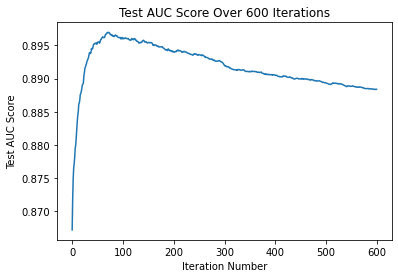

In [34]:
cv_results_big = xgb.cv(params, Dtrain, num_boost_round = 600, nfold=10, shuffle = True)

# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print(np.mean(cv_results_big['test-auc-mean']))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

Notice that the test AUC score never quite reaches 1.0 and begins to decrease slightly after 100 iterations. This is because this much cross-validation can actually cause the model to become overfit. So, there is a limit to how much cross-validation you should to.

### Cross-validation scoring
Now, you should use cross-validation scoring with cross_val_score() to check the overall performance.

This is exercise presents an excellent opportunity to test out the use of the hyperparameters learning_rate and max_depth. Remember, hyperparameters are like settings which can help create optimum performance.

In [35]:
# Import the module

from sklearn.model_selection import cross_val_score

# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              cv_scores.std() * 2))

C:\Users\Migue\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Undersampling training data
It's time to undersample the training set yourself with a few lines of code from Pandas. Once the undersampling is complete, you can check the value counts for loan_status to verify the results.

X_y_train, count_nondefault, and count_default are already loaded in the workspace.

In [36]:
### X_y_train, count_nondefault, and count_default 
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)

count_nondefault, count_default = X_y_train['loan_status'].value_counts()

# Create data sets for defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
print(X_y_train_under['loan_status'].value_counts())

1    3872
0    3872
Name: loan_status, dtype: int64


In [38]:
# prepare data
X_reduced = X_y_train_under.loc[:, X_y_train_under.columns !='loan_status']
y_reduced  = X_y_train_under['loan_status']

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=.4, random_state=123)

# Train model and predict
gbt4 = xgb.XGBClassifier().fit(X_train_reduced,np.ravel(y_train_reduced))
gbt4_preds = gbt4.predict(X_test_reduced)

# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test_reduced, gbt4_preds, target_names=target_names))

[12:53:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

 Non-Default       0.90      0.95      0.92      9194
     Default       0.77      0.62      0.69      2592

    accuracy                           0.88     11786
   macro avg       0.84      0.79      0.81     11786
weighted avg       0.87      0.88      0.87     11786

              precision    recall  f1-score   support

 Non-Default       0.79      0.82      0.80      1563
     Default       0.81      0.77      0.79      1535

    accuracy                           0.80      3098
   macro avg       0.80      0.80      0.80      3098
weighted avg       0.80      0.80      0.80      3098



In [41]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))
print(confusion_matrix(y_test_reduced,gbt4_preds))

[[8717  477]
 [ 973 1619]]
[[1281  282]
 [ 346 1189]]


In [42]:
from sklearn.metrics import roc_auc_score

# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds))
print(roc_auc_score(y_test_reduced,gbt4_preds))

0.7863662677887082
0.7970852845004908
